In [1]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from feature_extraction import graph_feature_extraction, seg_feature_extraction
from loader import hetero_graph_loader
from utils import prep
from matplotlib import pyplot as plt
import numpy as np
import torch 
import pandas as pd
from evaluation import evaluation

from itertools import product

from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle


In [2]:
octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 2, "Early NPDR": 1, "Late NPDR": 1}

data_type = "DCP"

vessel_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_vessel_graph"
void_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_void_graph"
hetero_edges_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_heter_edges"
label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv"


train_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = "train",
                                                        label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv", 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)

test_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = "test",
                                                        label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv", 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)

In [3]:

# do data imputation
prep.hetero_graph_imputation(train_dataset)
prep.hetero_graph_imputation(test_dataset)

prep.add_node_features(train_dataset, ["graph_1", "graph_2"])
prep.add_node_features(test_dataset, ["graph_1", "graph_2"])

# extract graph features
train_g_extractor = graph_feature_extraction.GraphFeatureExtractor(train_dataset.hetero_graphs, mode=torch.mean)# 
train_g_feature_dict = train_g_extractor.get_feature_dict()
train_g_faz_feature_dict = train_g_extractor.get_faz_feature_dict()

test_g_extractor = graph_feature_extraction.GraphFeatureExtractor(test_dataset.hetero_graphs, mode=torch.mean)# 
test_g_feature_dict = test_g_extractor.get_feature_dict()
test_g_faz_feature_dict = test_g_extractor.get_faz_feature_dict()

prep.add_global_node(train_dataset)
prep.add_global_node(test_dataset)


In [4]:
train_dataset[0].x_dict["global"]

tensor([[6.9080e+03, 2.7696e+04, 8.0185e+00, 1.8610e+03, 7.1360e+03, 7.6690e+00,
         8.6420e+03, 0.0000e+00]])

In [5]:
octa_dr_dict_update = {"Healthy": 0, "DM": 0, "PDR": 2, "Early NPDR": 1, "Late NPDR": 1}
train_dataset.update_class(octa_dr_dict_update)
test_dataset.update_class(octa_dr_dict_update)

num_classes = np.unique(list(octa_dr_dict_update.values())).shape[0]
print(f"Number of classes: {num_classes}")

Number of classes: 3


In [6]:
#extract segmentation features
seg_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_seg"
seg_extractor = seg_feature_extraction.SegFeatureExtractor(seg_path)
seg_feature_dict = seg_extractor.get_feature_dict()


In [7]:
train_comb_feature_dict = prep.create_combined_feature_dict(train_g_feature_dict,train_g_faz_feature_dict, seg_feature_dict, train_dataset)
test_comb_feature_dict = prep.create_combined_feature_dict(test_g_feature_dict,test_g_faz_feature_dict, seg_feature_dict, test_dataset)

In [8]:
x_train = np.array([val[0] for val in train_comb_feature_dict.values()])
y_train = np.array([val[1] for val in train_comb_feature_dict.values()])

x_test = np.array([val[0] for val in test_comb_feature_dict.values()])
y_test = np.array([val[1] for val in test_comb_feature_dict.values()])

In [9]:
param_grid_rf = {'max_depth': [4, 5, 6, 8], 'max_features': ["sqrt", "log2"], 'class_weight': ['balanced','balanced_subsample', None], 'n_estimators': [100,  300]} 


best_params = None
best_metric = 0

# Hyperparameter search loop
for param_set in product(*param_grid_rf.values()):
    current_params = dict(zip(param_grid_rf.keys(), param_set))

    # Train the model on the training set
    current_model = RandomForestClassifier(**current_params) 
    current_model.fit(x_train, y_train)

    # Evaluate on the validation set
    val_predictions = current_model.predict(x_test)
    val_prob_pred = current_model.predict_proba(x_test)
    current_accuracy = balanced_accuracy_score(y_test, val_predictions)
    if num_classes == 2:
        current_auc = roc_auc_score(
            y_true=y_test,
            y_score = val_prob_pred[:,1],
            multi_class="ovr",
            average="macro",
        )
    else:
        current_auc = roc_auc_score(
            y_true=y_test,
            y_score = val_prob_pred,
            multi_class="ovr",
            average="macro",
        )
    kappa = cohen_kappa_score(y_test, val_predictions, weights="quadratic") # , weights="quadratic"
    metric =  kappa

    # Update best parameters if current model is better
    if metric > best_metric:
        best_metric = metric
        best_params = current_params
        print(best_metric)


rf_best = RandomForestClassifier(**best_params) # , class_weight='balanced'
_=rf_best.fit(x_train, y_train)


0.6766462703962703
0.6782737543989628
0.6810620248980941
0.6892347799417268
0.6911758966553487
0.694233206590621


{'max_depth': 8, 'max_features': 'sqrt', 'class_weight': 'balanced', 'n_estimators': 300}
0.7875647668393783
0.5782476024411508


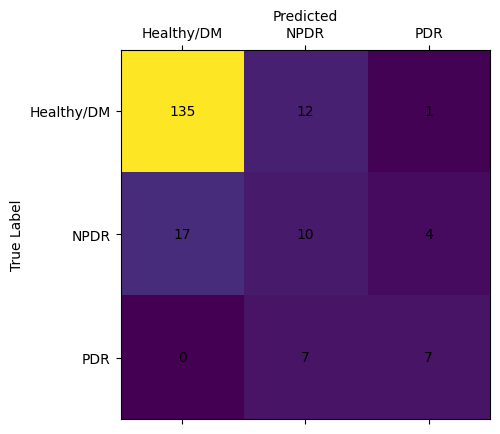

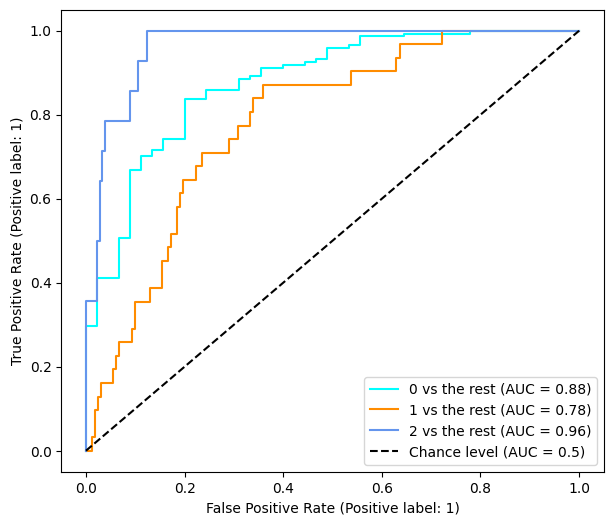

0.87550598480696
0.6656429640129145


In [10]:
print(best_params)
labels = ["Healthy/DM", "NPDR", "PDR"]

y_p = rf_best.predict(x_test)
print(accuracy_score(y_test, y_p))
print(balanced_accuracy_score(y_test, y_p))
fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_test, y_p, labels, ax) #, ["Healthy/DM","PDR", "NPDR"]"Early NPDR", "Late NPDR" , 3, 4 # ["Healthy/DM", "PDR", "NPDR"]
plt.show()


y_prob = rf_best.predict_proba(x_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)


fig, ax = plt.subplots(figsize=(7, 6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])

if num_classes == 2:
    RocCurveDisplay.from_predictions(
        y_test,
        y_prob[:, 1],
        name="ROC curve",
        ax=ax,
        color="red",
    )
else:
    for class_id, color in zip(range(num_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_prob[:, class_id],
            name=f"{class_id} vs the rest",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )


if num_classes == 2:
    mean_auc = roc_auc_score(
        y_true=y_test,
        y_score = y_prob[:,1],
        multi_class="ovr",
        average="macro",
    )
else:
    mean_auc = roc_auc_score(
        y_true=y_test,
        y_score = y_prob,
        multi_class="ovr",
        average="macro",
    )
plt.show()
print(mean_auc)

print(cohen_kappa_score(y_test, y_p, weights="quadratic"))

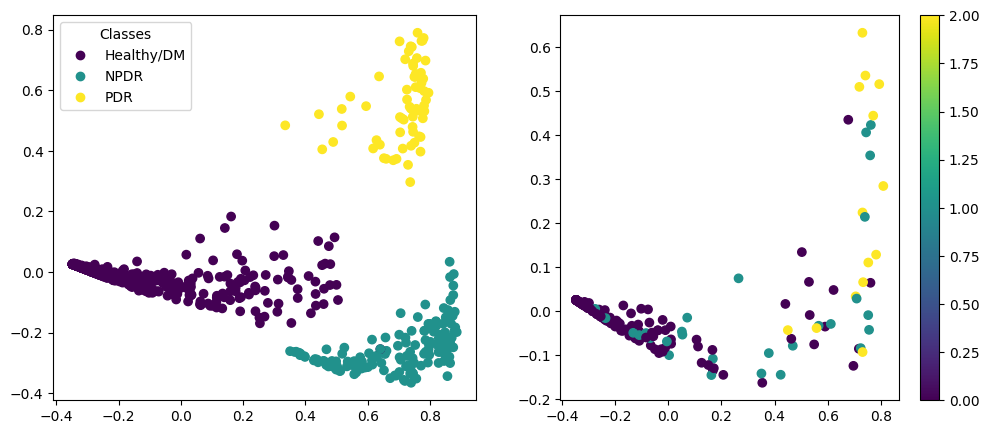

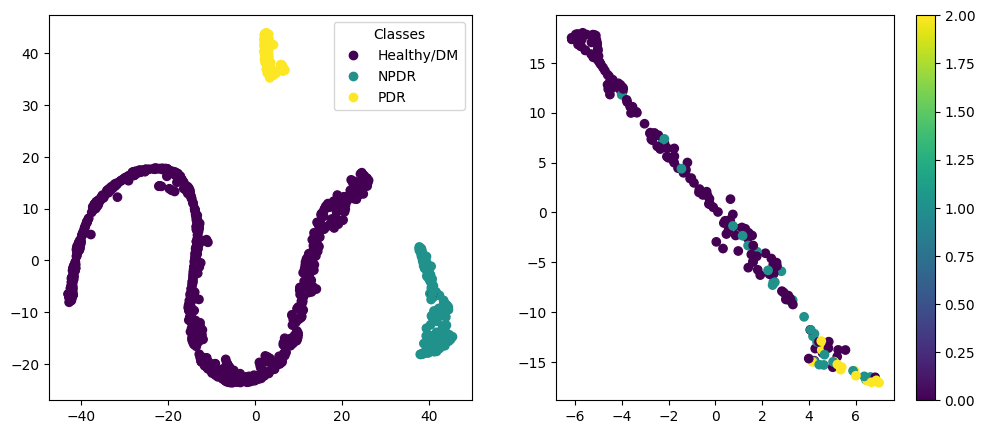

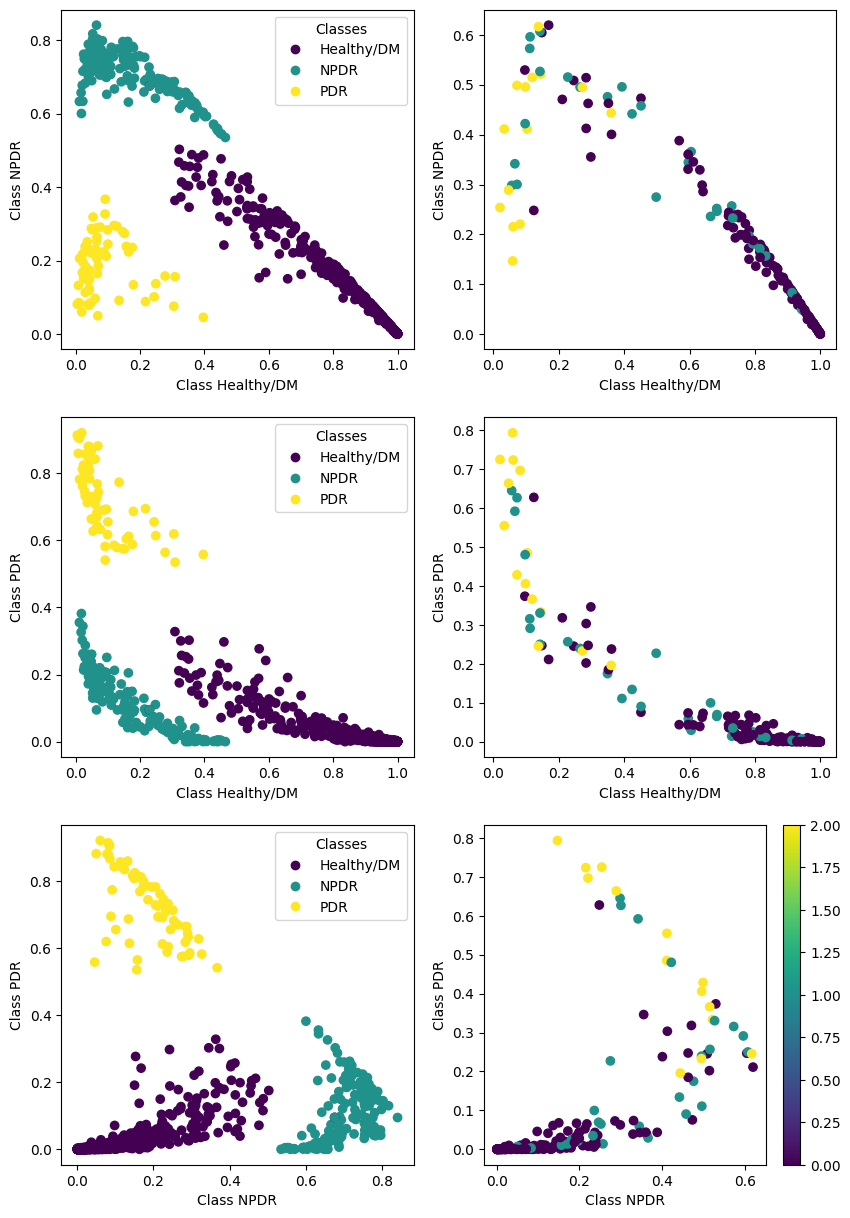

In [11]:
# tsne embedding for visualization
y_prob_train = rf_best.predict_proba(x_train)
y_prob_test = rf_best.predict_proba(x_test)

evaluation.pca_transform_plot(y_prob_train, y_prob_test, y_train, y_test, labels)
evaluation.tsne_transform_plot(y_prob_train, y_prob_test, y_train, y_test, labels)
evaluation.embedding_plot(y_prob_train, y_prob_test, y_train, y_test, labels)

In [12]:
graph_1_features = ["length",
                        "distance",	
                        "curveness",	
                        "volume",	    
                        "avgCrossSection",	
                        "minRadiusAvg",	
                        "minRadiusStd",	
                        "avgRadiusAvg",
                        "avgRadiusStd",	
                        "maxRadiusAvg",	
                        "maxRadiusStd",	
                        "roundnessAvg",
                        "roundnessStd",	
                        "node1_degree",	
                        "node2_degree",	
                        "num_voxels",	
                        "hasNodeAtSampleBorder", 
                        "degree", 
                        "hetero_degree"]


graph_2_featues = ['centroid-0', 
                        "centroid-1",
                        'area',
                        'perimeter',
                        'eccentricity',
                        'equivalent_diameter',
                        'orientation',
                        'solidity',
                        'feret_diameter_max',
                        'extent',
                        'axis_major_length',
                        'axis_minor_length',
                        "intensity_max",
                        "intensity_mean",
                        "intensity_min",
                        "centroid_weighted-0",
                        "centroid_weighted-1",
                        "degree",
                        "hetero_degree"]


global_node_features = ["node_num_graph_1", 
                            "edge_num_graph_1", 
                            "avg_deg_graph_1",
                            "node_num_graph_2", 
                            "edge_num_graph_2",
                             "avg_deg_graph_2", 
                             "hetero_edge_num", 
                             "eye"]


faz_features = graph_2_featues.copy()
for feature in faz_features:
    faz_features[faz_features.index(feature)] = "faz_" + feature

seg_features = ["global_mask_ratio", "top_left_ratio", "top_right_ratio", "bottom_left_ratio", "bottom_right_ratio"]



feature_names = graph_1_features + graph_2_featues + global_node_features+ faz_features + seg_features
print(len(feature_names))

70


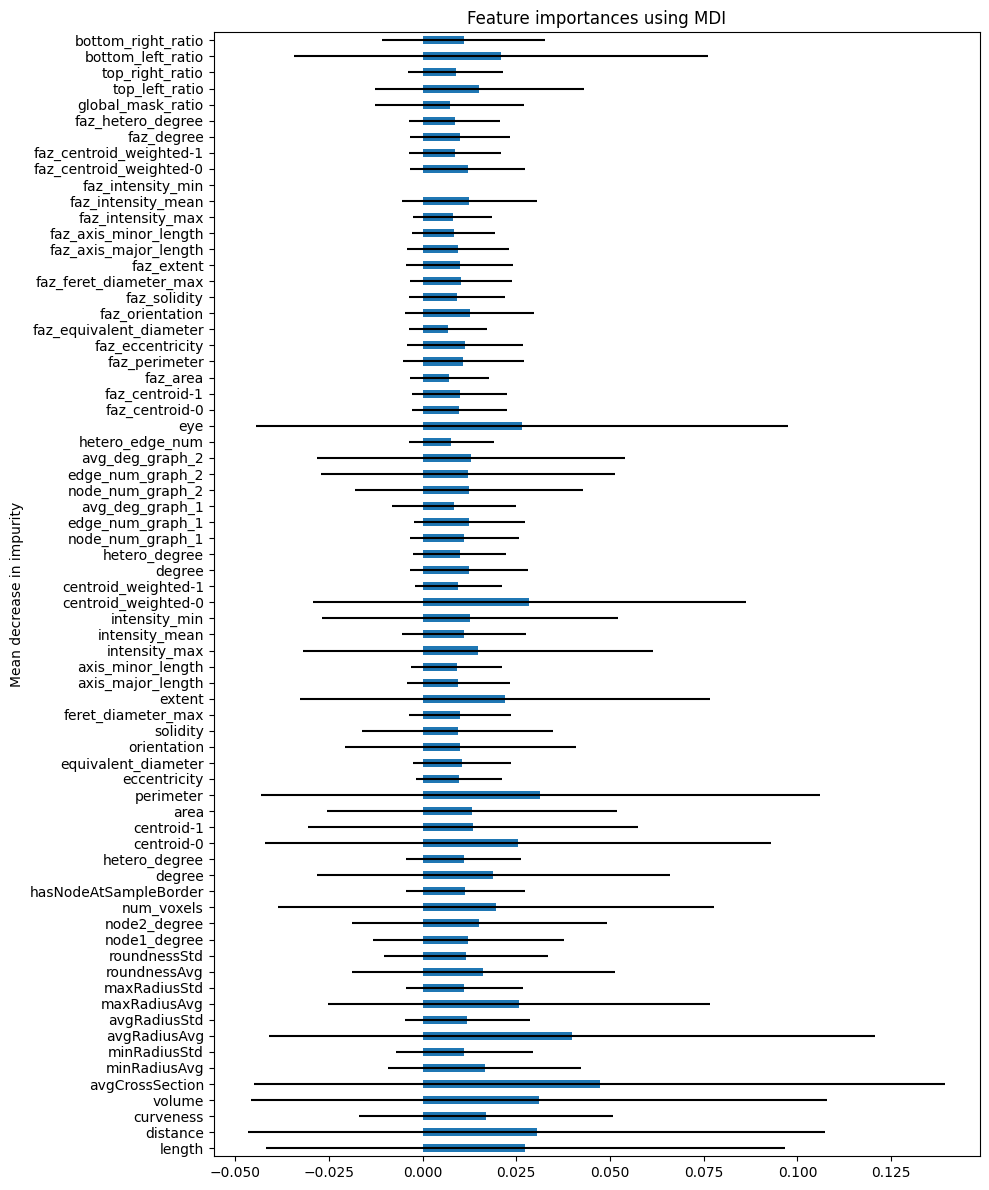

In [13]:
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots(figsize=(10, 12))

forest_importances.plot.barh(xerr=std, ax=ax)
# add feature names as x-axis labels, avoid overwriting
ax.set_yticklabels(feature_names) # , rotation=90
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()



# last features are the segmentation features

In [14]:
#param_grid = {'learning_rate' : [0.5, 0.1, 0.01], 'max_iter' : [100,200]}  #HistGradientBoostingClassifier

#param_grid = {'n_estimators': [100,  300]}  #AdaBoostClassifier

param_grid = {'C' : [0.1, 1], 'gamma' : [0.1, 1], 'kernel' : ["rbf", "linear"] , 'probability' : [True]} #SVC #, "poly", "sigmoid"

best_params = None
best_metric = 0

# Hyperparameter search loop
for param_set in product(*param_grid.values()):
    current_params = dict(zip(param_grid.keys(), param_set))

    # Train the model on the training set
    current_model = SVC(**current_params) 
    current_model.fit(x_train, y_train)

    # Evaluate on the validation set
    val_predictions = current_model.predict(x_test)
    val_prob_pred = current_model.predict_proba(x_test)
    current_accuracy = balanced_accuracy_score(y_test, val_predictions)
    if num_classes == 2:
        current_auc = roc_auc_score(
            y_true=y_test,
            y_score = val_prob_pred[:,1],
            multi_class="ovr",
            average="macro",
        )
    else:
        current_auc = roc_auc_score(
            y_true=y_test,
            y_score = val_prob_pred,
            multi_class="ovr",
            average="macro",
        )
    kappa = cohen_kappa_score(y_test, val_predictions, weights="quadratic") # , weights="quadratic"
    metric =  kappa

    # Update best parameters if current model is better
    if metric > best_metric:
        best_metric = metric
        best_params = current_params
        print(best_metric)


alt_cls_best = SVC(**best_params) # , class_weight='balanced'
_=alt_cls_best.fit(x_train, y_train)


0.684820173939463


{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}
0.8238341968911918
0.6155706397641881


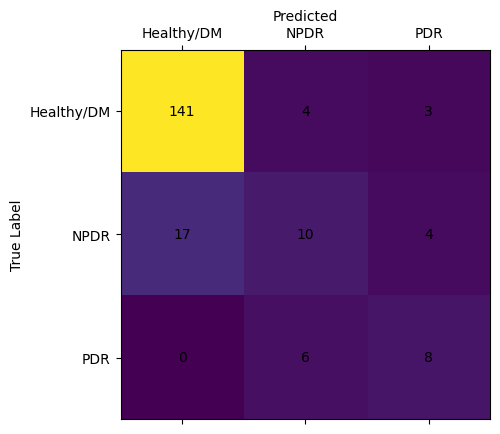

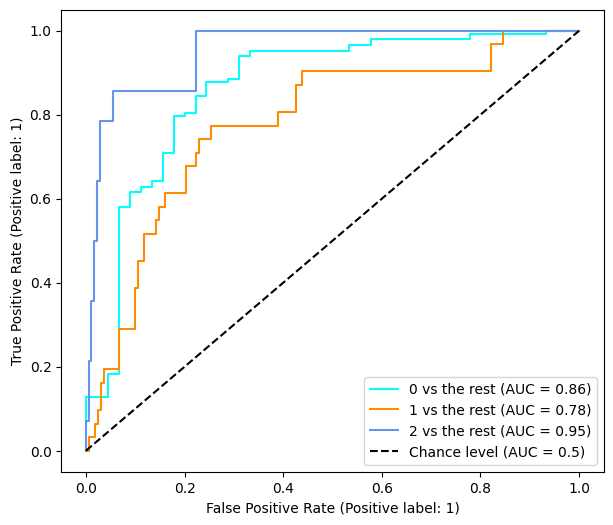

0.8656493097433406
0.684820173939463


In [15]:
print(best_params)
labels = ["Healthy/DM", "NPDR", "PDR"]

y_p = alt_cls_best.predict(x_test)
print(accuracy_score(y_test, y_p))
print(balanced_accuracy_score(y_test, y_p))
fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_test, y_p, labels, ax) #, ["Healthy/DM","PDR", "NPDR"]"Early NPDR", "Late NPDR" , 3, 4 # ["Healthy/DM", "PDR", "NPDR"]
plt.show()


y_prob = alt_cls_best.predict_proba(x_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)


fig, ax = plt.subplots(figsize=(7, 6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])

if num_classes == 2:
    RocCurveDisplay.from_predictions(
        y_test,
        y_prob[:, 1],
        name="ROC curve",
        ax=ax,
        color="red",
    )
else:
    for class_id, color in zip(range(num_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_prob[:, class_id],
            name=f"{class_id} vs the rest",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )


if num_classes == 2:
    mean_auc = roc_auc_score(
        y_true=y_test,
        y_score = y_prob[:,1],
        multi_class="ovr",
        average="macro",
    )
else:
    mean_auc = roc_auc_score(
        y_true=y_test,
        y_score = y_prob,
        multi_class="ovr",
        average="macro",
    )
plt.show()
print(mean_auc)

print(cohen_kappa_score(y_test, y_p, weights="quadratic"))